# Retention Time Prediction 

This notebook is prepared to be run in Google [Colaboratory](https://colab.research.google.com/). In order to train the model faster, please change the runtime of Colab to use Hardware Accelerator, either GPU or TPU.

This notebook presents a short walkthrough the process of reading a dataset and training a model for retention time prediction. The dataset is an example dataset extracted from a ProteomTools dataset generated in the **Chair of Bioanalytics** at the **Technical University of Munich**.

The framework being used is a custom wrapper on top of Keras/TensorFlow. The working name of the package is for now DLOmix -  `dlomix`.

In [1]:
# install the DLOmix package in the current environment using pip

!python -m pip install -q git+https://github.com/wilhelm-lab/dlomix

The available modules in the framework are as follows:

In [2]:
import numpy as np
import pandas as pd
import dlomix
from dlomix import constants, data, eval, layers, models, pipelines, reports, utils
print([x for x in dir(dlomix) if not x.startswith("_")])

['constants', 'data', 'eval', 'layers', 'models', 'pipelines', 'reports', 'utils']


- `constants`: constants to be used in the framework (e.g. Aminoacid alphabet mapping)
- `data`:  classes for representing dataset, wrappers around TensorFlow Dataset
- `eval`: custom evaluation metrics implemented in Keras/TF to work as `metrics` for model training
- `layers`: custom layer implementation required for the different models
- `models`: different model implementations for Retention Time Prediction
- `pipelines`: complete pipelines to run a task (e.g. Retention Time prediction)
- `utils`: helper modules

**Note**: reports and pipelines are work-in-progress, some funtionalities are not complete.

## 1. Load Data

We can import the dataset class and create an object of type `RetentionTimeDataset`. This object wraps around TensorFlow dataset objects for training+validation or for testing. This can be specified by the arguments `val_ratio` and `test`.

In [3]:
from dlomix.data import RetentionTimeDataset

In [4]:
TRAIN_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix/develop/example_dataset/proteomTools_train_val.csv'
BATCH_SIZE = 64

rtdata = RetentionTimeDataset(data_source=TRAIN_DATAPATH,
                              seq_length=30, batch_size=BATCH_SIZE, val_ratio=0.2, test=False)

2022-01-16 19:27:26.641554: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-16 19:27:27.069302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5317 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


Now we have an RT dataset that can be used directly with standard or custom `Keras` models. This wrapper contains the splits we chose when creating it. In our case, they are training and validation splits. To get the TF Dataset, we call the attributes `.train_data` and `.val_data`. The length is now in batches (i.e. `total examples = batch_size x len`)

In [5]:
 "Training examples", BATCH_SIZE * len(rtdata.train_data)

('Training examples', 27136)

In [6]:
"Validation examples", BATCH_SIZE * len(rtdata.val_data)

('Validation examples', 6784)

## 2. Model

We can now create the model. We will use a simple Prediction with a conv1D encoder. It has the default working arguments, but most of the parameters can be customized.

**Note**: Important is to ensure that the padding length used for the dataset object is equal to the sequence length passed to the model.

In [7]:
from dlomix.models import RetentionTimePredictor

In [8]:
model = RetentionTimePredictor(seq_length=30)

## 3. Training

We can then train the model like a standard Keras model. The training parameters here are from Prosit, but other optimizer parameters can be used.  

In [9]:
#imports

from dlomix.eval import TimeDeltaMetric

In [10]:
# compile the model  with the optimizer and the metrics we want to use, we can add our custom timedelta metric

# you can also import tensorflow and build your custom optimizer object and pass it

model.compile(optimizer='adam', 
              loss='mse',
              metrics=['mean_absolute_error', TimeDeltaMetric()])

We store the result of training so that we can explore the metrics and the losses later. We specify the number of epochs for training and pass the training and validation data as previously described.

In [11]:
history = model.fit(rtdata.train_data,
                    validation_data=rtdata.val_data,
                    epochs=20)

Epoch 1/20


2022-01-16 19:27:28.546431: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


424/424 [==============================] - 5s 8ms/step - loss: 742.7579 - mean_absolute_error: 19.4122 - timedelta: 20.1925 - val_loss: 214.1380 - val_mean_absolute_error: 10.7669 - val_timedelta: 9.9843
Epoch 2/20
424/424 [==============================] - 3s 8ms/step - loss: 157.9462 - mean_absolute_error: 9.2085 - timedelta: 9.7049 - val_loss: 137.7420 - val_mean_absolute_error: 8.3740 - val_timedelta: 7.9539
Epoch 3/20
424/424 [==============================] - 3s 8ms/step - loss: 122.2989 - mean_absolute_error: 7.9660 - timedelta: 8.4341 - val_loss: 108.8932 - val_mean_absolute_error: 7.4178 - val_timedelta: 7.3360
Epoch 4/20
424/424 [==============================] - 3s 8ms/step - loss: 104.7814 - mean_absolute_error: 7.2858 - timedelta: 7.7214 - val_loss: 95.8553 - val_mean_absolute_error: 6.9747 - val_timedelta: 6.9988
Epoch 5/20
424/424 [==============================] - 3s 8ms/step - loss: 94.0043 - mean_absolute_error: 6.8407 - timedelta: 7.1669 - val_loss: 88.5219 - val_mea

## 3. Testing and Reporting

We can create a test dataset to test our model. Additionally, we can use the reporting module to produce plots and evaluate the model.

Note: the reporting module is still in progress and some functionalities might easily break.

In [12]:
# create the dataset object for test data

TEST_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix/develop/example_dataset/proteomTools_test.csv'

test_rtdata = RetentionTimeDataset(data_source=TEST_DATAPATH,
                              seq_length=30, batch_size=32, test=True)

In [13]:
# use model.predict from keras directly on the testdata

predictions = model.predict(test_rtdata.test_data)

# we use ravel from numpy to flatten the array (since it comes out as an array of arrays)
predictions = predictions.ravel()

In [14]:
# we can get the targets of a specific split to calcualte evaluation metrics against predictions
# the get_split_targets function from the RetentionTime dataset does this

test_targets = test_rtdata.get_split_targets(split="test")

In [15]:
test_targets, predictions

(array([160.87262216,  -9.96731383,   1.6301965 , ...,  43.60962035,
         29.89127059,  70.90945116]),
 array([156.30185  ,  -9.100542 ,   5.9167724, ...,  41.084408 ,
         29.417599 ,  71.111    ], dtype=float32))

In [16]:
from dlomix.reports import RetentionTimeReport

In [17]:
# create a report object by passing the history object and plot different metrics
report = RetentionTimeReport(output_path="./output", history=history)

.png


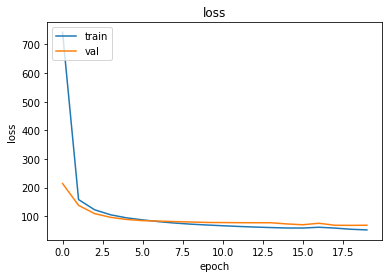

In [18]:
report.plot_keras_metric("loss")

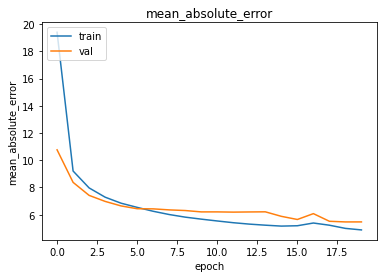

In [19]:
report.plot_keras_metric("mean_absolute_error")

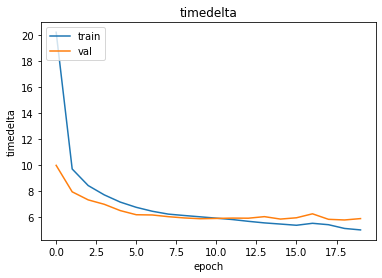

In [20]:
report.plot_keras_metric("timedelta")

In [21]:
# calculate R2  given the targets and the predictions of the test data
report.calculate_r2(test_targets, predictions)

0.9665102749319594

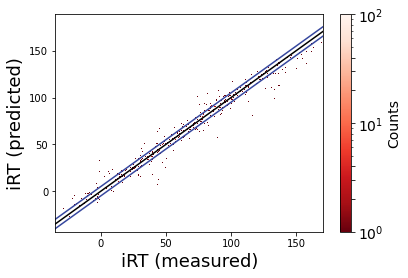

In [22]:
report.plot_density(test_targets, predictions)

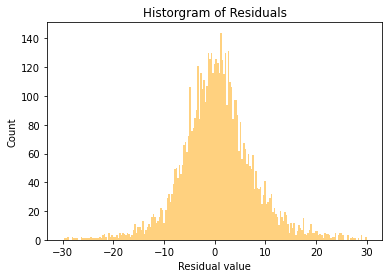

In [23]:
report.plot_residuals(test_targets, predictions, xrange=(-30, 30))

We can also produce a complete report with all the relevant plots in one PDF file by calling the `generate_report` function.

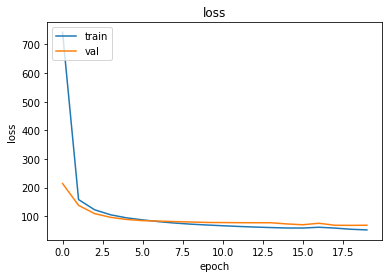

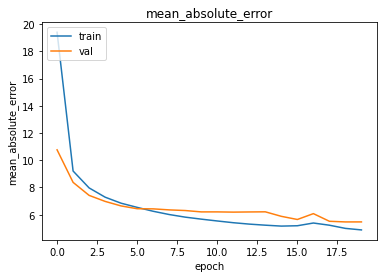

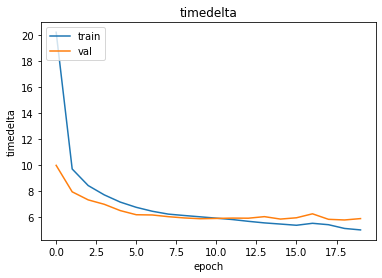

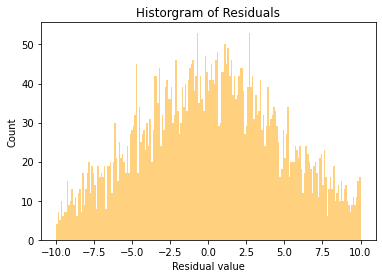

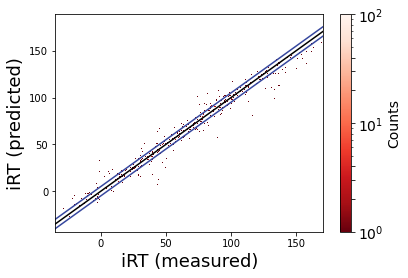

['./output/loss.png', './output/timedelta.png', './output/density_plot.png', './output/mean_absolute_error.png', './output/histogram_residuals.png']


In [24]:
report.generate_report(test_targets, predictions)

## 4. Saving and Loading Models

Models can be saved normally the same Keras models would be saved. It is better to save the weights and the not the model since it makes it easier and more platform-indepdent when loading the model again. The extra step needed is to create a model object and then load the weights.

In [25]:
# save the model weights

save_path = "./output/rtmodel"
model.save_weights(save_path)

In [26]:
# models can be later loaded by creating a model object and then loading the weights

trained_model = RetentionTimePredictor(seq_length=30)
trained_model.load_weights(save_path)

We can compare the predictions to make sure that the model was loaded correctly.

In [27]:
new_predictions = trained_model.predict(test_rtdata.test_data)

In [28]:
new_predictions = new_predictions.ravel()

In [29]:
# confirm all old and new predictions are the same
np.allclose(predictions, new_predictions)

True

In [30]:
results_df = pd.DataFrame({"sequence": test_rtdata.sequences,
                           "irt": test_rtdata.targets,
                           "predicted_irt": predictions})

results_df.to_csv("./output/predictions_irt.csv", index=False)

In [31]:
pd.read_csv("./output/predictions_irt.csv")

,sequence,irt,predicted_irt
0,IAAGLGPSYSGSLLLFDALR,160.872622,156.301850
1,KKISEEDLR,-9.967314,-9.100542
2,HAFTCRVAGGPGTPR,1.630197,5.916772
3,LNDGHFMPVLGFGTYAPPEVPR,108.566269,112.320870
4,MITPEDVK,14.768607,19.656810
...,...,...,...
5976,VAPPGLTQIPQIQK,83.372074,77.090020
5977,SELGSFITDYFQNQLLAK,161.185058,164.037750
5978,TYRPLVNDISEAK,43.609620,41.084408
5979,EITNQVVPQER,29.891271,29.417599
